<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/model_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of accuracy before and after adding new classes nodes at the final linear layer with different initialization**

In this notebook we are going to analyse how accuracy drops after adding new classes nodes at the last liner layer. Also we would analyse how different initialization methods affect the drop of accuracy.

In [ ]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 270 (delta 80), reused 65 (delta 36), pack-reused 145
Receiving objects: 100% (270/270), 45.06 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [ ]:
_use_wandb = False
if _use_wandb:
  !pip install wandb -q

# Preprocessing of data and architecture related code:



In [ ]:
import numpy as np
import torch
import models
from dataset import SubsetSC
from torch.utils.data import DataLoader
import copy
import torch.nn.functional as F
import torch.nn as nn
from utils import label_to_index, index_to_label, get_average_of_list
import os
from statistics import mean
from datetime import datetime
from IPython.display import display
import pandas as  pd
import matplotlib.pyplot as plt

In [ ]:
if _use_wandb:
  !wandb login
  import wandb

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [5, 5]

In [ ]:
#list of novel class targets that we'd use for further training 
random_targets = ['follow']

#here we need training data for New/Novel class
traindata = SubsetSC("training", "novel", novel_class_list= random_targets)
testdata = SubsetSC("testing", "novel", novel_class_list= random_targets)

#for classification labels would be combination of novel classes and old classes(digits)
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
total_targets_list =  digits +random_targets

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(total_targets_list, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets
        
novel_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)
novel_test_dataloader = DataLoader(testdata, batch_size = 20, collate_fn=collate_fn, shuffle=True)

#Old data to evaluate accuracy for old classes
old_testdata = SubsetSC("testing", "old")
old_test_dataloader = DataLoader(old_testdata,batch_size=10, collate_fn=collate_fn, shuffle=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

# Accuracy analysis

we have created function for evaluation of accuracy

In [ ]:
#to store logs
logs = []

init_labels = {
 'negative' : 'Negative',
 'negative_norm' : 'Negative_Norm',
 'random' : 'Random',
 'random_norm' : 'Random_Norm',
 'xavier_uniform' : 'Xavier_Uniform',
 'xavier_uniform_norm' : 'Xavier_Uniform_Norm',
 'xavier_normal' : 'Xavier_Normal',
 'xavier_normal_norm' : 'Xavier_Normal_Norm',
 'kaiming_uniform' : 'Kaiming_Uniform',
 'kaiming_uniform_norm' : 'Kaiming_Uniform_Norm',
 'kaiming_normal' : 'Kaiming_Normal',
 'kaiming_normal_norm' : 'Kaiming_Normal_Norm'
}

def evaluate_model(model, place, _with = ''):
  old_class_accuracy=[]
  with torch.no_grad():
    model.eval()
    for i, (inputs, labels) in enumerate(old_test_dataloader):
      logits = model(inputs)
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      old_class_accuracy.append(acc)
  print(f'old class accuracy {place} initialization {_with}: {sum(old_class_accuracy)/len(old_class_accuracy):.2f}') 

def _normalization(old_weights,  incremental_model_linear_weights):
  # L2 regularization of weights
  old_weights_norm = torch.norm(old_weights, p=2, dim=1)
  incremental_model_linear_weights_norm = torch.norm(incremental_model_linear_weights, p=2, dim=1)
  old_weights_mean = torch.mean(old_weights_norm)
  incremental_model_linear_weights_mean = torch.mean(incremental_model_linear_weights_norm)
  gamma = old_weights_mean+incremental_model_linear_weights_mean
  old_weights = old_weights/gamma
  incremental_model_linear_weights = incremental_model_linear_weights/gamma

  return old_weights, incremental_model_linear_weights
  
def _incremental_model(model, init_method = init_labels['random'], is_normalize = False):
  in_features = model.linear.in_features
  out_features = model.linear.out_features
  incremental_model_linear = nn.Linear(in_features=in_features, out_features=len(random_targets))
  
  #Initialize weights 
  if init_method == init_labels['negative']:
    print(f'Initialization: {init_method}')
    nn.init.constant_(incremental_model_linear.weight, -1)
  elif init_method == init_labels['xavier_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_uniform_(incremental_model_linear.weight)
  elif init_method == init_labels['xavier_normal']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_normal_(incremental_model_linear.weight)
  elif init_method == init_labels['kaiming_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_uniform_(incremental_model_linear.weight, nonlinearity='linear')
  elif init_method == init_labels['kaiming_normal']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_normal_(incremental_model_linear.weight)

  nn.init.constant_(incremental_model_linear.bias, 0)

  old_weights = copy.deepcopy(model.linear.weight.data)
  old_bias = copy.deepcopy(model.linear.bias.data)
  incremental_model_linear_weights = copy.deepcopy(incremental_model_linear.weight.data)
  incremental_model_linear_bias = copy.deepcopy(incremental_model_linear.bias.data)
  model.linear = nn.Linear(in_features=in_features, out_features=len(total_targets_list))

  if is_normalize:
    #if L2 normalization is used
    print('w/ L2 normalization')
    old_weights, incremental_model_linear_weights = _normalization(old_weights,  incremental_model_linear_weights
                                                                   )
  new_weights = torch.cat([old_weights, incremental_model_linear_weights], dim=0)
  new_bias = torch.cat([old_bias, incremental_model_linear_bias] ,dim=0)
  model.linear.weight.data = new_weights
  model.linear.bias.data = new_bias

  return model


def _train(model, train_dataloader, project_name = 'test-project'):
  if _use_wandb:
    wandb.init(project=project_name)
    wandb.watch(model)
  _optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
  model.train()
  train_loss = []
  train_acc = []
  for epoch in range(20):
    running_loss = []
    running_acc = []
    for i, (inputs, labels) in enumerate(train_dataloader):
      logits = model(inputs)
      loss = F.cross_entropy(logits, labels)
      _optimizer.zero_grad()
      loss.backward()
      _optimizer.step()
      running_loss.append(loss.item())
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      running_acc.append(acc)
      if _use_wandb:
        wandb.log({"loss": loss})
        wandb.log({"accuracy": acc})
    
    print(f"Epoch [{epoch}]...Loss: {mean(running_loss)} Accuracy: {mean(running_acc)}")
    train_loss.append(mean(running_loss))
    train_acc.append(mean(running_acc))
  
  logs.append({
    'id': str(datetime.now().date()) + '_' + str(datetime.now().time()).replace(':', '.'),
    'init': project_name,
    'loss': train_loss,
    'accuracy': train_acc
  })


In [ ]:
pretrained_model_path= "./savedmodels/vgg_checkpoint.pth"

***Let's check accuracies with different initialization method:***

Here are few links for the understanding of different initialization methods available in pytorch: 



1.   [pytorch link](https://pytorch.org/docs/stable/nn.init.html)
2.   [xavier initialization](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/)
3. [Different model initialization](https://www.askpython.com/python-modules/initialize-model-weights-pytorch)


we are going to compare following initialization methods and respective accuracies


0. initialization with small negative value e.g. "-1"
1.   Random 
2.   Xavier uniform 
3. Xavier normal 
4. Kaiming uniform
5. Kaiming normal

**Experiment:**

1. With all of the aforementioned methods, we compared the accuracy before and after initialization.

2. Afterwards we compared the accuracy afer initilization with normalization of the weights

3. Also, we analysed loss and accuracy with respect to all initialization and weight normalization methods during training on neural netwrok for novel class

4. We compared logits of first few methods to analyse prediction after forward pass.


**Observation:**

1. Other initialization approaches, except the small negative value(-1) initialization, have dramatically reduced accuracy.

2. However, for negative initialization, convergence rate for loss to zero is very slow as compared to others. 

3. There is a treadoff between old novel class accuracy and learning rate of neural network for new classes. Even though negative initialization allows us to maintain the original accuracy of old clsses, this method is the slowest while learning novel class. If we select other initilizations, the neural network can learn much faster. 

4. Another factor to consider is Normalization of weights for the last layer. Even if we have good accuracy for old classes after initialization, it is not enough to make the network learn novel classes while preserving the old accuracy. The Old clss weights are already well learned on old dataset and only need small modifications for new dataset. Compared to that, there is a disparity in the learning behaviour of the new weights which are randomly initialized. Thus these two different levels of weights could be problematic for learning new data and preserving the old. Thus there is need of normalization after initialization of weights.   


---


```markdown


                |  Old Class Accuracy             |     Novel class accuracy after  training for 10             
Initialization  | Before class    |After class    |After class Increm|After class    |After class Increment
.               |Increment        |Increment      |w/ Normalization  |increment      |w/ Normalization.
----------------|-----------------|---------------|------------------|---------------|----------------------------------
Negative        | 0.95            | 0.95          | 0.92             | 0.97          | 1.0
Random          | 0.95            | 0.71          | 0.75             | 1.0           | 1.0
Xavier uniform  | 0.95            | 0.78          | 0.64             | 1.0           | 1.0
Xavier normal   | 0.95            | 0.67          | 0.78             | 1.0           | 1.0
Kaiming uniform | 0.95            | 0.72          | 0.73             | 1.0           | 1.0
Kaiming normal  | 0.95            | 0.82          | 0.67             | 1.0           | 1.0


```



---



As you can see, negative initialization (o. section) has smaller values in logits even for new nodes after the forward pass and also falls under the similar range of old class(pre-trained) values. However, new class have significantly greater values than old class, in the case of other methods e.g. random initialization (1. section). Since the network predicts values based on higer probability it predicts novel classes even for old classes, as a result the accuracy immediately decreases after initialization.




**0. Initialization with small negative value**

In this method we will initialize our new nodes with small negative value e.g.-1 to keep same accuracy post initialization of new nodes in the neural networks.

In [ ]:
#todo: add weight distibution and 
#accuracy graph after few epoch for trainig on novel classes: to train and see which is trainig faster 
#and more efficient 
#depending on that we can choose efficeient initialization and normalization method 
#for all other training algorithms



In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

#Add weights at the last linear layer for novel class 
model = _incremental_model(model, init_labels['negative'])

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

#training analysis
_train(model, novel_train_dataloader, init_labels['negative']) 

old class accuracy before initialization : 0.95
Initialization: Negative
old class accuracy after initialization : 0.95
Epoch [0]...Loss: 233.04756608794008 Accuracy: 0.0
Epoch [1]...Loss: 69.9975598130045 Accuracy: 0.0
Epoch [2]...Loss: 38.99445313441603 Accuracy: 0.5258161225849434
Epoch [3]...Loss: 24.368976339509217 Accuracy: 0.7018321119253831
Epoch [4]...Loss: 20.175018256223655 Accuracy: 0.750566289140573
Epoch [5]...Loss: 16.21688617633868 Accuracy: 0.7948700866089274
Epoch [6]...Loss: 13.013795095154002 Accuracy: 0.8164223850766156
Epoch [7]...Loss: 9.640816300730162 Accuracy: 0.8575283144570286
Epoch [8]...Loss: 9.453544100628623 Accuracy: 0.8759493670886076
Epoch [9]...Loss: 7.604033014442347 Accuracy: 0.8935376415722851
Epoch [10]...Loss: 7.590866349920442 Accuracy: 0.890506329113924
Epoch [11]...Loss: 5.952997485293618 Accuracy: 0.9195869420386409
Epoch [12]...Loss: 5.892997230155559 Accuracy: 0.9240506329113924
Epoch [13]...Loss: 4.061724572242061 Accuracy: 0.940506329113

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, init_labels['negative'], is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after', 'with normalization')

_train(model, novel_train_dataloader, init_labels['negative_norm'])

Initialization: Negative
w/ L2 normalization
old class accuracy after initialization with normalization: 0.92
Epoch [0]...Loss: 3.90238203051724 Accuracy: 0.3169553630912725
Epoch [1]...Loss: 0.5698769092088258 Accuracy: 0.8962025316455696
Epoch [2]...Loss: 0.11319946122690637 Accuracy: 0.990506329113924
Epoch [3]...Loss: 0.014426014819765355 Accuracy: 0.9993670886075949
Epoch [4]...Loss: 1.6280045409555883e-05 Accuracy: 1.0
Epoch [5]...Loss: 3.3611770092995198e-06 Accuracy: 1.0
Epoch [6]...Loss: 2.046970573300484e-05 Accuracy: 1.0
Epoch [7]...Loss: 3.108155730977108e-05 Accuracy: 1.0
Epoch [8]...Loss: 1.4370458175663913e-06 Accuracy: 1.0
Epoch [9]...Loss: 5.6358284430289824e-08 Accuracy: 1.0
Epoch [10]...Loss: 1.9163914539654234e-08 Accuracy: 1.0
Epoch [11]...Loss: 7.448734912362243e-07 Accuracy: 1.0
Epoch [12]...Loss: 6.564032175750854e-09 Accuracy: 1.0
Epoch [13]...Loss: 4.149685242403313e-09 Accuracy: 1.0
Epoch [14]...Loss: 3.568682186891571e-08 Accuracy: 1.0
Epoch [15]...Loss: 9.8

In [ ]:
input, labels = next(iter(old_test_dataloader))
logits = model(input)
#print all logits for given inputs
#Here we have 10 inputs and we will get 10x13 logits (10 old + 3 novel classes)
print("Logits with small negative values initialization:")
display(pd.DataFrame(logits.detach().numpy()))
print(f"Corresponding actual labels: {labels}")
_, pred = logits.max(1)
print(f"Predicted values: {pred}")

Logits with small negative values initialization:


,0,1,2,3,4,5,6,7,8,9,10
0,-40.024876,-39.576214,-37.512768,-39.474049,-39.342094,-40.070072,-36.759220,-38.177185,-40.059029,-40.243561,26.429712
1,-39.140965,-38.732071,-37.631496,-38.679794,-37.749592,-38.234703,-37.697109,-38.014797,-38.337818,-39.285328,30.420780
2,-28.206518,-26.445993,-27.322720,-28.393747,-26.787605,-27.921137,-28.456388,-28.679588,-26.945251,-27.348207,22.566704
3,-56.301796,-56.634678,-62.756565,-58.424942,-60.060352,-54.448498,-53.903179,-57.944103,-59.043861,-54.218990,6.817823
4,-84.476082,-77.725227,-78.580360,-75.119911,-76.856415,-78.270912,-71.774788,-74.716019,-83.324806,-77.800842,22.674158
5,-52.990410,-58.730492,-49.012829,-47.825523,-55.339970,-53.997173,-50.100204,-52.141453,-50.750423,-53.473209,5.054775
6,-33.446468,-34.579025,-32.629307,-31.433104,-32.837059,-33.951817,-30.842638,-32.663021,-33.971928,-34.191402,24.536581
7,-84.123734,-77.289482,-79.797913,-74.078789,-78.779953,-77.542519,-75.406998,-71.346481,-81.968452,-75.359940,30.535273
8,-36.163952,-36.877472,-34.366806,-34.540249,-34.811974,-32.245178,-33.090672,-34.448399,-34.568359,-34.741730,17.903193
9,-37.109165,-41.797749,-35.105858,-39.658123,-39.883888,-37.602150,-34.840462,-37.159691,-39.391396,-40.189674,12.548805


Corresponding actual labels: tensor([6, 2, 1, 9, 9, 3, 0, 9, 0, 2])
Predicted values: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


In logits table we can observe, column 10, 11 and 12 values (novel classes) are very small compared to other columns(col 0 till col 9: old classes). Therefore predicted lables are almost similar to actual labels.

**1. With random initialization**

This is default initialization method in pytorch

As you can see at the output, accuracy of previous data reduces after addition of new nodes at the final layer and initialize with random initilaization.

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

model = _incremental_model(model)

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['random'])

old class accuracy before initialization : 0.95
old class accuracy after initialization : 0.71
Epoch [0]...Loss: 0.43104572460846896 Accuracy: 0.9537641572285143
Epoch [1]...Loss: 0.07588869630821601 Accuracy: 0.9860093271152565
Epoch [2]...Loss: 0.06995879313063853 Accuracy: 0.9949367088607595
Epoch [3]...Loss: 0.011024193169516468 Accuracy: 0.9981012658227848
Epoch [4]...Loss: 0.02680090868651075 Accuracy: 0.9993670886075949
Epoch [5]...Loss: 0.00017397673430169584 Accuracy: 1.0
Epoch [6]...Loss: 0.0005540845042720998 Accuracy: 0.9993670886075949
Epoch [7]...Loss: 3.2065458181793033e-08 Accuracy: 1.0
Epoch [8]...Loss: 5.4452964421632057e-08 Accuracy: 1.0
Epoch [9]...Loss: 0.008161314756044265 Accuracy: 0.9993670886075949
Epoch [10]...Loss: 0.0 Accuracy: 1.0
Epoch [11]...Loss: 1.584425215500969e-09 Accuracy: 1.0
Epoch [12]...Loss: 6.035910336944239e-10 Accuracy: 1.0
Epoch [13]...Loss: 4.526933427274067e-10 Accuracy: 1.0
Epoch [14]...Loss: 9.053863256863397e-10 Accuracy: 1.0
Epoch [15]

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['random_norm'])

w/ L2 normalization
old class accuracy after initialization : 0.75
Epoch [0]...Loss: 0.051467137738738795 Accuracy: 0.9898734177215189
Epoch [1]...Loss: 0.0021851350236569357 Accuracy: 1.0
Epoch [2]...Loss: 0.0007005521585805389 Accuracy: 1.0
Epoch [3]...Loss: 0.000251784632085657 Accuracy: 1.0
Epoch [4]...Loss: 8.41732817155626e-05 Accuracy: 1.0
Epoch [5]...Loss: 6.952591566410778e-06 Accuracy: 1.0
Epoch [6]...Loss: 6.439217436155013e-06 Accuracy: 1.0
Epoch [7]...Loss: 5.644148620251275e-06 Accuracy: 1.0
Epoch [8]...Loss: 9.00304359479835e-07 Accuracy: 1.0
Epoch [9]...Loss: 3.2615740876028854e-06 Accuracy: 1.0
Epoch [10]...Loss: 7.997570313454783e-09 Accuracy: 1.0
Epoch [11]...Loss: 3.242721434043653e-07 Accuracy: 1.0
Epoch [12]...Loss: 4.526934326695252e-10 Accuracy: 1.0
Epoch [13]...Loss: 1.6221421325729387e-08 Accuracy: 1.0
Epoch [14]...Loss: 1.207181527736137e-09 Accuracy: 1.0
Epoch [15]...Loss: 1.0562843764218306e-09 Accuracy: 1.0
Epoch [16]...Loss: 2.1125662344643445e-09 Accurac

In [ ]:
input, labels = next(iter(old_test_dataloader))
logits = model(input)
print("Logits with random initialization:")
display(pd.DataFrame(logits.detach().numpy()))
print(f"Corresponding actual labels: {labels}")
_, pred = logits.max(1)
print(f"Predicted values: {pred}")

Logits with random initialization:


,0,1,2,3,4,5,6,7,8,9,10
0,-44.710243,-55.358128,-54.210159,-50.728325,-68.727119,-60.849552,-45.793831,-56.265724,-48.199295,-59.201374,30.181183
1,-145.010803,-184.469635,-186.327103,-162.106918,-239.453720,-205.733749,-164.111221,-223.057648,-173.432709,-221.243622,96.556168
2,-50.638229,-70.191063,-61.456718,-55.538651,-81.089272,-80.578575,-57.779182,-61.585644,-67.474541,-71.854935,46.503517
3,-119.320190,-119.250366,-121.520828,-108.778061,-143.836090,-84.484680,-114.253845,-110.497612,-97.350853,-110.448517,61.442505
4,-60.978363,-54.791473,-64.764000,-69.535767,-62.278721,-42.817741,-53.187462,-49.186840,-54.927231,-54.960716,27.205835
5,-32.721428,-37.917126,-33.288174,-40.332653,-40.694847,-46.632801,-39.267727,-34.862316,-40.287010,-46.108383,32.153622
6,-21.546804,-23.400349,-25.174452,-26.098797,-33.849762,-30.501854,-27.499714,-24.870701,-21.091730,-28.995121,28.012226
7,-69.636620,-98.311485,-91.709854,-66.275505,-105.803322,-91.253845,-70.512749,-101.865379,-74.363358,-84.298843,59.778164
8,-55.581329,-78.897797,-78.849861,-73.191452,-94.914627,-95.255333,-62.903938,-79.831718,-62.975231,-82.728012,50.029385
9,-50.562462,-97.266045,-68.229416,-81.946907,-88.460159,-99.592300,-66.938835,-64.004944,-62.717625,-99.526764,82.355850


Corresponding actual labels: tensor([2, 3, 0, 5, 5, 6, 4, 1, 0, 6])
Predicted values: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


Contrary to negative initialization, column 10, 11, and 12 values (new classes) in the logits table are higher than those of the other columns (col 0 till col 9: old classes). The majority of predicted labels therefore have novel class prediction rather than old class prediction.

**2. With Xavier uniform initialization**

Xavier is used for sigmoid and Tanh non linear activation functions.

Distribution: $U(-a, a)$



$a = gain * \sqrt{\frac{6}{input dim + output dim}}$


$gain$ is a scaling factor

$input dim$ dimension of prvious layer

$output dim$ diamension of preceding layer



In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

model = _incremental_model(model, init_labels['xavier_uniform'])

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['xavier_uniform'])

old class accuracy before initialization : 0.95
Initialization: Xavier_Uniform
old class accuracy after initialization : 0.78
Epoch [0]...Loss: 0.6617785366212979 Accuracy: 0.950632911392405
Epoch [1]...Loss: 0.08508899914034143 Accuracy: 0.989840106595603
Epoch [2]...Loss: 0.018750340728852472 Accuracy: 0.9949367088607595
Epoch [3]...Loss: 0.002217112273950253 Accuracy: 0.9987341772151899
Epoch [4]...Loss: 0.0036357145993773975 Accuracy: 0.9993670886075949
Epoch [5]...Loss: 0.000983744671070128 Accuracy: 0.9993670886075949
Epoch [6]...Loss: 1.6372202676566188e-08 Accuracy: 1.0
Epoch [7]...Loss: 0.0 Accuracy: 1.0
Epoch [8]...Loss: 3.968488606086437e-08 Accuracy: 1.0
Epoch [9]...Loss: 7.393954365793549e-09 Accuracy: 1.0
Epoch [10]...Loss: 3.744050586704626e-06 Accuracy: 1.0
Epoch [11]...Loss: 0.0 Accuracy: 1.0
Epoch [12]...Loss: 0.0 Accuracy: 1.0
Epoch [13]...Loss: 0.0 Accuracy: 1.0
Epoch [14]...Loss: 1.5089781463743e-10 Accuracy: 1.0
Epoch [15]...Loss: 0.0 Accuracy: 1.0
Epoch [16]...Lo

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, init_labels['xavier_uniform'], is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['xavier_uniform_norm'])

Initialization: Xavier_Uniform
w/ L2 normalization
old class accuracy after initialization : 0.64
Epoch [0]...Loss: 0.0495839478644477 Accuracy: 0.9911392405063291
Epoch [1]...Loss: 0.0016341231493835295 Accuracy: 1.0
Epoch [2]...Loss: 0.00046575918902325576 Accuracy: 1.0
Epoch [3]...Loss: 0.0007519771216619843 Accuracy: 1.0
Epoch [4]...Loss: 3.762451820166494e-05 Accuracy: 1.0
Epoch [5]...Loss: 4.421904073007197e-05 Accuracy: 1.0
Epoch [6]...Loss: 2.366454330485107e-06 Accuracy: 1.0
Epoch [7]...Loss: 1.1286442255048982e-07 Accuracy: 1.0
Epoch [8]...Loss: 2.9399416704723747e-05 Accuracy: 1.0
Epoch [9]...Loss: 1.3580796459282167e-09 Accuracy: 1.0
Epoch [10]...Loss: 3.017956405176248e-10 Accuracy: 1.0
Epoch [11]...Loss: 1.5089781463743e-10 Accuracy: 1.0
Epoch [12]...Loss: 5.305231404676467e-09 Accuracy: 1.0
Epoch [13]...Loss: 1.398691718845206e-07 Accuracy: 1.0
Epoch [14]...Loss: 5.6586478512766505e-09 Accuracy: 1.0
Epoch [15]...Loss: 2.7010140262240947e-08 Accuracy: 1.0
Epoch [16]...Los

In [ ]:
input, labels = next(iter(old_test_dataloader))
logits = model(input)
print("Logits with xavier uniform initialization:")
display(pd.DataFrame(logits.detach().numpy()))
print(f"Corresponding actual labels: {labels}")
_, pred = logits.max(1)
print(f"Predicted values: {pred}")

Logits with xavier uniform initialization:


,0,1,2,3,4,5,6,7,8,9,10
0,-57.504906,-67.291702,-69.546425,-66.634666,-95.239784,-77.991295,-48.218361,-77.166473,-64.004227,-83.742256,35.163490
1,-111.272430,-94.058113,-107.576157,-105.435455,-121.145508,-105.232323,-100.429359,-112.604347,-120.684364,-113.011063,67.597382
2,-50.404572,-38.443108,-49.759277,-47.730900,-60.796951,-44.350174,-30.673046,-46.077061,-46.309021,-52.051334,33.241165
3,-78.583893,-78.742218,-80.711166,-78.270844,-91.656387,-74.057037,-73.129242,-82.333015,-77.737610,-67.573608,60.481308
4,-48.822655,-40.567795,-44.233868,-34.271763,-43.257957,-45.921360,-35.688530,-44.875660,-44.513870,-39.595406,28.315783
5,-42.986820,-47.469658,-44.690704,-54.709438,-56.964100,-53.173313,-43.265537,-50.575428,-54.185043,-48.104294,37.313576
6,-70.626717,-68.697411,-70.322105,-78.676758,-57.106026,-81.448883,-65.094757,-81.106255,-71.762184,-77.014565,41.044216
7,-149.391464,-171.148102,-142.999466,-129.651642,-139.614441,-130.159470,-134.075333,-137.493744,-144.835495,-157.939758,81.118256
8,-124.154343,-83.484138,-114.135239,-108.932701,-90.167274,-65.376518,-108.709244,-93.109093,-108.292725,-87.786491,55.683754
9,-58.969379,-45.237877,-60.056976,-50.754875,-68.315552,-62.410927,-55.397163,-55.411179,-56.629410,-54.271946,41.335690


Corresponding actual labels: tensor([6, 1, 6, 9, 7, 3, 4, 6, 5, 4])
Predicted values: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


**3. With Xavier normal initialization**

Distribution: $N(0, σ^2)$



$σ = gain * \sqrt{\frac{2}{input dim + output dim}}$


In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

model = _incremental_model(model, init_labels['xavier_normal'])

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['xavier_normal'])

old class accuracy before initialization : 0.95
Initialization: Xavier_Normal
old class accuracy after initialization : 0.67
Epoch [0]...Loss: 0.5489154383436864 Accuracy: 0.9512658227848101
Epoch [1]...Loss: 0.04972831803223599 Accuracy: 0.9892405063291139
Epoch [2]...Loss: 0.046396924733785296 Accuracy: 0.9924050632911392
Epoch [3]...Loss: 0.02718313546610135 Accuracy: 0.9974683544303797
Epoch [4]...Loss: 0.0016787006315111324 Accuracy: 0.9993670886075949
Epoch [5]...Loss: 0.0057945072953125825 Accuracy: 0.9987341772151899
Epoch [6]...Loss: 0.0015601921160025103 Accuracy: 0.9987341772151899
Epoch [7]...Loss: 2.1793636414511718e-07 Accuracy: 1.0
Epoch [8]...Loss: 2.927384065674448e-08 Accuracy: 1.0
Epoch [9]...Loss: 1.0336465635598674e-08 Accuracy: 1.0
Epoch [10]...Loss: 0.012271353958428077 Accuracy: 0.9993670886075949
Epoch [11]...Loss: 0.0 Accuracy: 1.0
Epoch [12]...Loss: 8.148430700928174e-09 Accuracy: 1.0
Epoch [13]...Loss: 0.0 Accuracy: 1.0
Epoch [14]...Loss: 7.54489129400974e-1

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, init_labels['xavier_normal'], is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['xavier_normal_norm'])

Initialization: Xavier_Normal
w/ L2 normalization
old class accuracy after initialization : 0.78
Epoch [0]...Loss: 0.04407713226126493 Accuracy: 0.9917721518987341
Epoch [1]...Loss: 0.002864274858461046 Accuracy: 1.0
Epoch [2]...Loss: 0.0006967065189538129 Accuracy: 1.0
Epoch [3]...Loss: 0.0007703708393572102 Accuracy: 1.0
Epoch [4]...Loss: 1.4322084248465252e-06 Accuracy: 1.0
Epoch [5]...Loss: 3.2302290133761124e-06 Accuracy: 1.0
Epoch [6]...Loss: 7.163158005879733e-07 Accuracy: 1.0
Epoch [7]...Loss: 1.3247603794824603e-07 Accuracy: 1.0
Epoch [8]...Loss: 4.1384737651995893e-07 Accuracy: 1.0
Epoch [9]...Loss: 1.131733289361928e-09 Accuracy: 1.0
Epoch [10]...Loss: 1.1317327721947469e-09 Accuracy: 1.0
Epoch [11]...Loss: 4.179734978379921e-08 Accuracy: 1.0
Epoch [12]...Loss: 6.4885898510709336e-09 Accuracy: 1.0
Epoch [13]...Loss: 1.3580796684137465e-09 Accuracy: 1.0
Epoch [14]...Loss: 3.421854617604468e-07 Accuracy: 1.0
Epoch [15]...Loss: 7.997540834925462e-09 Accuracy: 1.0
Epoch [16]...L

In [ ]:
input, labels = next(iter(old_test_dataloader))
logits = model(input)
print("Logits with Xaviour normal initialization:")
display(pd.DataFrame(logits.detach().numpy()))
print(f"Corresponding actual labels: {labels}")
_, pred = logits.max(1)
print(f"Predicted values: {pred}")

Logits with Xaviour normal initialization:


,0,1,2,3,4,5,6,7,8,9,10
0,-53.622341,-48.340416,-59.253517,-48.620102,-80.993233,-51.826164,-41.609013,-53.736515,-50.509216,-49.749580,39.920841
1,-56.845787,-68.538078,-63.707874,-64.704948,-83.740158,-79.727966,-44.776077,-55.963188,-63.873268,-61.288181,36.145493
2,-50.370842,-52.905460,-60.220718,-53.393360,-52.845436,-57.196808,-54.150917,-55.561893,-51.333809,-62.407883,35.291512
3,-71.238991,-80.486473,-81.871620,-76.587532,-99.883965,-72.252197,-74.349236,-67.555672,-69.890816,-85.309052,38.967407
4,-72.037498,-104.638908,-105.089615,-87.847343,-108.142059,-98.474960,-88.161926,-80.658348,-89.589531,-106.814110,51.876366
5,-44.882210,-47.097500,-49.338188,-48.667625,-30.454161,-46.055252,-45.586727,-46.819420,-47.648598,-51.362251,22.380941
6,-80.643669,-108.602592,-95.186623,-83.000999,-93.222542,-100.640450,-63.167068,-76.531387,-72.461273,-109.418945,46.621197
7,-81.213356,-66.703552,-67.465813,-63.597820,-96.788719,-63.483280,-54.956902,-57.518177,-69.745399,-68.530014,45.887108
8,-46.314823,-66.402580,-43.649902,-55.735081,-59.749977,-65.857529,-36.670891,-47.410393,-45.371391,-60.226089,25.438097
9,-89.266174,-88.300407,-101.101906,-101.458115,-100.622322,-113.061356,-84.315079,-99.898041,-96.457977,-99.968185,47.449852


Corresponding actual labels: tensor([5, 6, 7, 7, 7, 1, 7, 5, 0, 4])
Predicted values: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


**4. With Kaiming uniform initilization**

Kaiming is used for RELU and LeakyRELU activation function

Distribution: $U(-a, a)$



$a = gain * \sqrt{\frac{3}{in features / out features}}$

$Fan Mode$ would be fan_in(default) or fan_out. Choosing 'fan_in' preserves the magnitude of the variance of the weights in the forward pass. Choosing 'fan_out' preserves the magnitudes in the backwards pass.


In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

model = _incremental_model(model, init_labels['kaiming_uniform'])

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['kaiming_uniform'])

old class accuracy before initialization : 0.95
Initialization: Kaiming_Uniform
old class accuracy after initialization : 0.72
Epoch [0]...Loss: 0.3716542148382484 Accuracy: 0.9556628914057295
Epoch [1]...Loss: 0.056739574006001936 Accuracy: 0.9892071952031979
Epoch [2]...Loss: 0.023297384428548187 Accuracy: 0.9955696202531645
Epoch [3]...Loss: 0.014683624299529826 Accuracy: 0.9968354430379747
Epoch [4]...Loss: 0.008907342028413142 Accuracy: 0.9993670886075949
Epoch [5]...Loss: 6.458112162624802e-08 Accuracy: 1.0
Epoch [6]...Loss: 3.1505281818663226e-06 Accuracy: 1.0
Epoch [7]...Loss: 0.00010573186422265326 Accuracy: 1.0
Epoch [8]...Loss: 1.6598740609844778e-09 Accuracy: 1.0
Epoch [9]...Loss: 7.54489129400974e-11 Accuracy: 1.0
Epoch [10]...Loss: 7.54489129400974e-11 Accuracy: 1.0
Epoch [11]...Loss: 6.667263157477107e-06 Accuracy: 1.0
Epoch [12]...Loss: 6.570200040889315e-06 Accuracy: 1.0
Epoch [13]...Loss: 0.0 Accuracy: 1.0
Epoch [14]...Loss: 0.0 Accuracy: 1.0
Epoch [15]...Loss: 0.0 Ac

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, init_labels['kaiming_uniform'], is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['kaiming_uniform_norm'])

Initialization: Kaiming_Uniform
w/ L2 normalization
old class accuracy after initialization : 0.73
Epoch [0]...Loss: 0.039263572484063085 Accuracy: 0.9911392405063291
Epoch [1]...Loss: 0.0011694077683885385 Accuracy: 1.0
Epoch [2]...Loss: 0.0017810578820028717 Accuracy: 1.0
Epoch [3]...Loss: 0.0006100610184028699 Accuracy: 1.0
Epoch [4]...Loss: 9.935080287461225e-06 Accuracy: 1.0
Epoch [5]...Loss: 8.81228623930816e-05 Accuracy: 1.0
Epoch [6]...Loss: 0.00016346688161740104 Accuracy: 1.0
Epoch [7]...Loss: 2.006932137214358e-08 Accuracy: 1.0
Epoch [8]...Loss: 4.6837116277100463e-07 Accuracy: 1.0
Epoch [9]...Loss: 5.7037021047129866e-08 Accuracy: 1.0
Epoch [10]...Loss: 2.1276404975398254e-08 Accuracy: 1.0
Epoch [11]...Loss: 8.54788978052573e-08 Accuracy: 1.0
Epoch [12]...Loss: 2.037117388980836e-09 Accuracy: 1.0
Epoch [13]...Loss: 7.544889495167371e-10 Accuracy: 1.0
Epoch [14]...Loss: 4.149555012961455e-08 Accuracy: 1.0
Epoch [15]...Loss: 1.0789117481281182e-08 Accuracy: 1.0
Epoch [16]...L

**5. With Kaiming normal initilization**

Distribution: $N(0, σ^2)$



$σ = gain * \sqrt{\frac{1}{in features  /  out features}}$

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
#Accuracy for old classes before initialization
evaluate_model(model, 'before')

model = _incremental_model(model, init_labels['kaiming_normal'])

#Accuracy for old classes after initialization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['kaiming_normal'])

old class accuracy before initialization : 0.95
Initialization: Kaiming_Normal
old class accuracy after initialization : 0.82
Epoch [0]...Loss: 0.7846915513299386 Accuracy: 0.9430379746835443
Epoch [1]...Loss: 0.1366620466827928 Accuracy: 0.9879413724183878
Epoch [2]...Loss: 0.10506487074896015 Accuracy: 0.9911392405063291
Epoch [3]...Loss: 0.020507460188437347 Accuracy: 0.9968354430379747
Epoch [4]...Loss: 0.004304938643542035 Accuracy: 0.9993670886075949
Epoch [5]...Loss: 0.031206849255139314 Accuracy: 0.9993670886075949
Epoch [6]...Loss: 0.0 Accuracy: 1.0
Epoch [7]...Loss: 0.0 Accuracy: 1.0
Epoch [8]...Loss: 0.0 Accuracy: 1.0
Epoch [9]...Loss: 0.0 Accuracy: 1.0
Epoch [10]...Loss: 0.0 Accuracy: 1.0
Epoch [11]...Loss: 0.0 Accuracy: 1.0
Epoch [12]...Loss: 0.0 Accuracy: 1.0
Epoch [13]...Loss: 0.0 Accuracy: 1.0
Epoch [14]...Loss: 0.0 Accuracy: 1.0
Epoch [15]...Loss: 1.3066402994187643e-07 Accuracy: 1.0
Epoch [16]...Loss: 1.8006681370301337e-05 Accuracy: 1.0
Epoch [17]...Loss: 0.0 Accurac

In [ ]:
model = models.VGGNet()
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

model = _incremental_model(model, init_labels['kaiming_normal'], is_normalize=True)

#Accuracy for old classes after initialization w/ normalization
evaluate_model(model, 'after')

_train(model, novel_train_dataloader, init_labels['kaiming_normal_norm'])

Initialization: Kaiming_Normal
w/ L2 normalization
old class accuracy after initialization : 0.67
Epoch [0]...Loss: 0.05304721753102146 Accuracy: 0.9892405063291139
Epoch [1]...Loss: 0.0025601420156405384 Accuracy: 0.9993670886075949
Epoch [2]...Loss: 0.0021541672539314026 Accuracy: 1.0
Epoch [3]...Loss: 0.00023789449667306986 Accuracy: 1.0
Epoch [4]...Loss: 8.158269329582006e-05 Accuracy: 1.0
Epoch [5]...Loss: 8.72943225828529e-06 Accuracy: 1.0
Epoch [6]...Loss: 6.714789852697803e-08 Accuracy: 1.0
Epoch [7]...Loss: 1.0064326974063361e-07 Accuracy: 1.0
Epoch [8]...Loss: 6.878369542913042e-06 Accuracy: 1.0
Epoch [9]...Loss: 1.961670477252874e-09 Accuracy: 1.0
Epoch [10]...Loss: 1.4486055269530073e-08 Accuracy: 1.0
Epoch [11]...Loss: 8.635628733281488e-07 Accuracy: 1.0
Epoch [12]...Loss: 0.0 Accuracy: 1.0
Epoch [13]...Loss: 7.54489129400974e-11 Accuracy: 1.0
Epoch [14]...Loss: 7.863089171845372e-07 Accuracy: 1.0
Epoch [15]...Loss: 4.526933427274067e-10 Accuracy: 1.0
Epoch [16]...Loss: 2.

# Visualization for the Effect of Normalization on the Training Loss for Novel class w.r.t Initialization Methods

In [ ]:
df = pd.DataFrame(logs)

In [ ]:
df.to_pickle("model_initilization_analysis.pkl")  
df

,id,init,loss,accuracy
0,2022-10-27_19.05.37.548603,Negative,"[233.04756608794008, 69.9975598130045, 38.9944...","[0.0, 0.0, 0.5258161225849434, 0.7018321119253..."
1,2022-10-27_19.07.47.586773,Negative_Norm,"[3.90238203051724, 0.5698769092088258, 0.11319...","[0.3169553630912725, 0.8962025316455696, 0.990..."
2,2022-10-27_19.10.02.563273,Random,"[0.43104572460846896, 0.07588869630821601, 0.0...","[0.9537641572285143, 0.9860093271152565, 0.994..."
3,2022-10-27_19.12.13.581439,Random_Norm,"[0.051467137738738795, 0.0021851350236569357, ...","[0.9898734177215189, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,2022-10-27_19.14.22.030728,Xavier_Uniform,"[0.6617785366212979, 0.08508899914034143, 0.01...","[0.950632911392405, 0.989840106595603, 0.99493..."
5,2022-10-27_19.16.31.149429,Xavier_Uniform_Norm,"[0.0495839478644477, 0.0016341231493835295, 0....","[0.9911392405063291, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,2022-10-27_19.18.42.678321,Xavier_Normal,"[0.5489154383436864, 0.04972831803223599, 0.04...","[0.9512658227848101, 0.9892405063291139, 0.992..."
7,2022-10-27_19.20.53.811648,Xavier_Normal_Norm,"[0.04407713226126493, 0.002864274858461046, 0....","[0.9917721518987341, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,2022-10-27_19.23.06.295326,Kaiming_Uniform,"[0.3716542148382484, 0.056739574006001936, 0.0...","[0.9556628914057295, 0.9892071952031979, 0.995..."
9,2022-10-27_19.25.15.919092,Kaiming_Uniform_Norm,"[0.039263572484063085, 0.0011694077683885385, ...","[0.9911392405063291, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
def plot_subplot(ax, label, idx:int, _dataframe, y_label):
  ax.plot(_dataframe.iloc[idx:idx+1,:].T, label = 'Standard', marker = 'o')
  ax.plot(_dataframe.iloc[idx+1:idx+2,:].T, label = 'w/ Normalization', marker = 'o')
  ax.legend()
  ax.set_title(label + '_Initilization', weight = 'bold')
  ax.set_xlabel('Epoch', weight = 'bold')
  ax.set_ylabel(y_label, weight = 'bold')

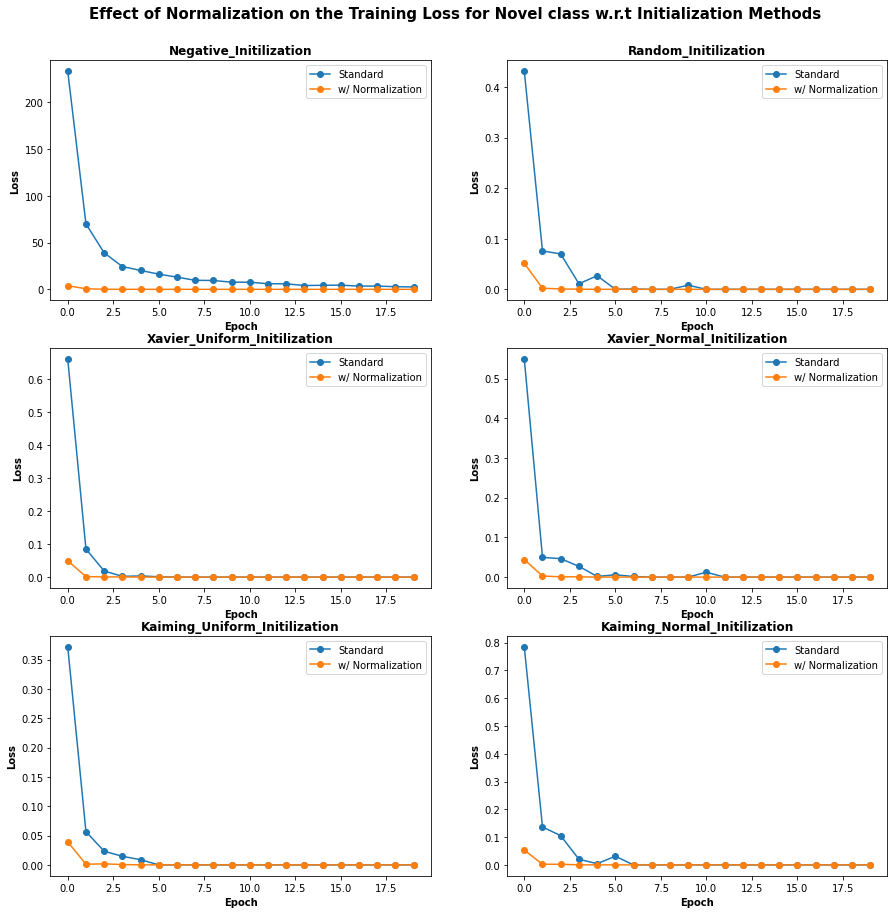

In [ ]:
from torch.nn.modules import normalization

plt.rcParams["figure.figsize"] = [15, 15]
fig, axes = plt.subplots(3, 2)
loss_df = pd.DataFrame(df)[['loss']].unstack().apply(pd.Series)
fig.suptitle('Effect of Normalization on the Training Loss for Novel class w.r.t Initialization Methods', fontsize=15, weight = 'extra bold', y=0.93)
plot_subplot(axes[0,0], init_labels['negative'], 0,  loss_df, 'Loss')
plot_subplot(axes[0,1], init_labels['random'], 2,  loss_df, 'Loss')
plot_subplot(axes[1,0], init_labels['xavier_uniform'], 4,  loss_df, 'Loss')
plot_subplot(axes[1,1], init_labels['xavier_normal'], 6,  loss_df, 'Loss')
plot_subplot(axes[2,0], init_labels['kaiming_uniform'], 8,  loss_df, 'Loss')
plot_subplot(axes[2,1], init_labels['kaiming_normal'], 10,  loss_df, 'Loss')

# fig.savefig("init_analysis_loss.png", format="png", dpi=600, bbox_inches="tight")
# fig.savefig("init_analysis_loss.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
# fig.savefig("init_analysis_loss.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)


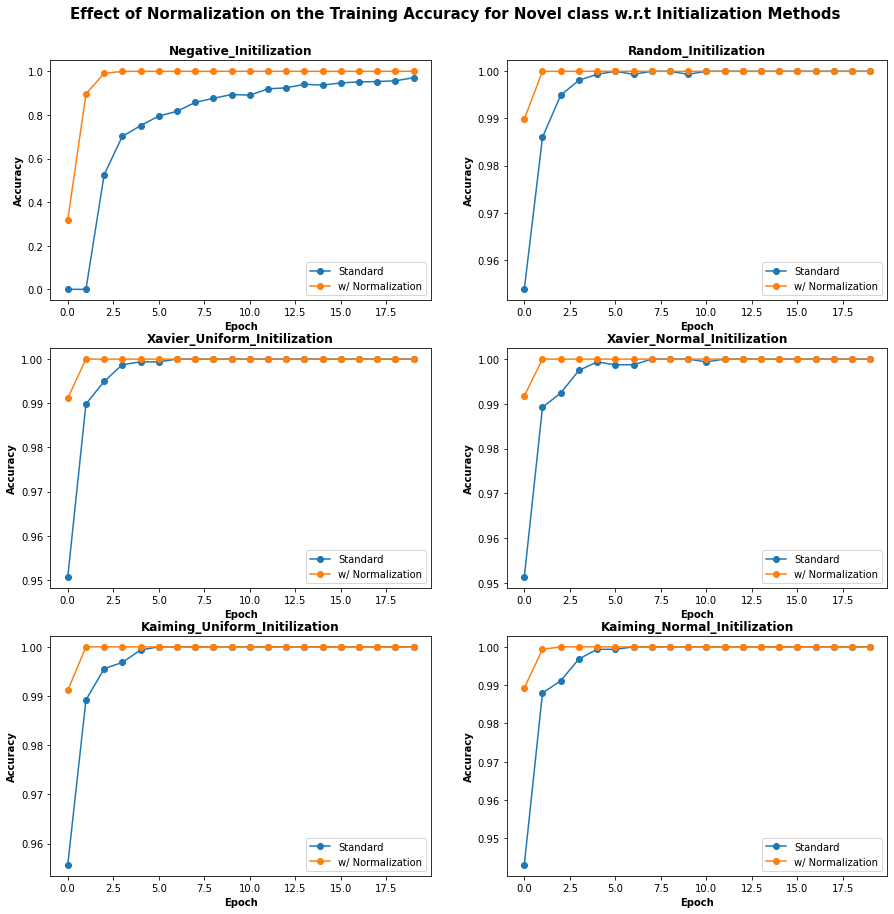

In [ ]:
fig, axes = plt.subplots(3, 2)
acc_df = pd.DataFrame(df)[['accuracy']].unstack().apply(pd.Series)

fig.suptitle('Effect of Normalization on the Training Accuracy for Novel class w.r.t Initialization Methods', fontsize=15, weight = 'extra bold', y=0.93)
plot_subplot(axes[0,0], init_labels['negative'], 0,  acc_df, 'Accuracy')
plot_subplot(axes[0,1], init_labels['random'], 2,  acc_df, 'Accuracy')
plot_subplot(axes[1,0], init_labels['xavier_uniform'], 4,  acc_df, 'Accuracy')
plot_subplot(axes[1,1], init_labels['xavier_normal'], 6,  acc_df, 'Accuracy')
plot_subplot(axes[2,0], init_labels['kaiming_uniform'], 8,  acc_df, 'Accuracy')
plot_subplot(axes[2,1], init_labels['kaiming_normal'], 10,  acc_df, 'Accuracy')



# fig.savefig("init_analysis_acc.png", format="png", dpi=600, bbox_inches="tight")
# fig.savefig("init_analysis_acc.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
# fig.savefig("init_analysis_acc.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)


As we can see, with negative weights takes longer to converge to zero loss than other methods. Even we have better old classes accuracy for negative initialization, other methods are more efficient in terms of fast converging to zero loss and better accuracy withing few epoch.    
